# PQF Pilot Experiment on BPI Challenge 2019 (Simulation)


- Chronological **train/validation/test** split with a **guard band**
- **Robust scaling** (median + MAD), fitted on train only
- Threshold calibration to target **α = 0.01** false-positive rate on validation normals
- Classical baselines: **Robust Z-score**, **PCA reconstruction error**, **KMeans distance-to-centroid**
- Quantum baseline: **PQF-like fidelity kernel** (Qiskit **statevector simulation**) + **One-Class SVM**
- Proxy labels via **controlled anomaly injection** (BPIC2019 has no anomaly annotations)

Outputs saved under: `outputs_pqf_bpic2019/`


In [1]:


import os
import time
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, Tuple, List

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_recall_curve, average_precision_score

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

plt.rcParams["figure.dpi"] = 140


In [2]:

# -----------------------------
# Configuration (thesis pilot)
# -----------------------------
CSV_PATH = "BPI_Challenge_2019.csv"  
OUT_DIR = "outputs_pqf_bpic2019"
SEED = 42

ALPHA = 0.01                 # target FPR on validation normals
N_QUBITS = 8                 # PQF "feature map" qubits (keep small for simulation)
DEPTH = 1                    # simple circuit depth
GUARD_DAYS = 7               # guard band width between splits
MAX_CASES_FOR_KERNEL = 900   # bound kernel size for feasibility in statevector simulation

# Feature extraction choices (simple, case-level)
MIN_YEAR = 2017              # drop timestamp outliers

os.makedirs(OUT_DIR, exist_ok=True)
rng = np.random.default_rng(SEED)

print("OUT_DIR:", OUT_DIR)


OUT_DIR: outputs_pqf_bpic2019


In [3]:

# -----------------------------
# Load BPIC2019 event log
# -----------------------------
df = pd.read_csv(CSV_PATH)
display(df.head(3))
print("Rows:", len(df), "Cols:", df.shape[1])
print("Columns:", list(df.columns))

# Try to find a timestamp column (BPIC logs vary)
ts_candidates = [c for c in df.columns if "time" in c.lower() or "date" in c.lower()]
print("Timestamp candidates:", ts_candidates[:20])


,User,org:resource,concept:name,Cumulative net worth (EUR),time:timestamp,case:Spend area text,case:Company,case:Document Type,case:Sub spend area text,case:Purchasing Document,...,case:Vendor,case:Item Type,case:Item Category,case:Spend classification text,case:Source,case:Name,case:GR-Based Inv. Verif.,case:Item,case:concept:name,case:Goods Receipt
0,batch_00,batch_00,SRM: Created,298.0,2018-01-02 12:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,1,2000000000_00001,True
1,batch_00,batch_00,SRM: Complete,298.0,2018-01-02 13:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,1,2000000000_00001,True
2,batch_00,batch_00,SRM: Awaiting Approval,298.0,2018-01-02 13:53:00+00:00,CAPEX & SOCS,companyID_0000,EC Purchase order,Facility Management,2000000000,...,vendorID_0000,Standard,"3-way match, invoice before GR",NPR,sourceSystemID_0000,vendor_0000,False,1,2000000000_00001,True


Rows: 1595923 Cols: 21
Columns: ['User', 'org:resource', 'concept:name', 'Cumulative net worth (EUR)', 'time:timestamp', 'case:Spend area text', 'case:Company', 'case:Document Type', 'case:Sub spend area text', 'case:Purchasing Document', 'case:Purch. Doc. Category name', 'case:Vendor', 'case:Item Type', 'case:Item Category', 'case:Spend classification text', 'case:Source', 'case:Name', 'case:GR-Based Inv. Verif.', 'case:Item', 'case:concept:name', 'case:Goods Receipt']
Timestamp candidates: ['time:timestamp']


In [4]:

# -----------------------------
# Parse timestamps (best-effort)
# -----------------------------
def find_timestamp_column(frame: pd.DataFrame) -> str:
    # Prefer common BPIC columns, otherwise pick first candidate.
    preferred = ["time:timestamp", "time_timestamp", "timestamp", "event_timestamp", "date", "datetime"]
    cols_lower = {c.lower(): c for c in frame.columns}
    for p in preferred:
        if p in cols_lower:
            return cols_lower[p]
    candidates = [c for c in frame.columns if "time" in c.lower() or "date" in c.lower()]
    if not candidates:
        raise ValueError("No timestamp-like column found.")
    return candidates[0]

TS_COL = find_timestamp_column(df)
print("Using timestamp column:", TS_COL)

df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce", utc=True)
df = df.dropna(subset=[TS_COL]).copy()
df["year"] = df[TS_COL].dt.year

# Remove clear outliers if present
df = df[df["year"] >= MIN_YEAR].copy()

print("After timestamp cleaning:", len(df), "rows")
print(df["year"].value_counts().sort_index().tail(10))


Using timestamp column: time:timestamp
After timestamp cleaning: 1595828 rows
year
2017        223
2018    1550468
2019      45135
2020          2
Name: count, dtype: int64


In [5]:

# -----------------------------
# Identify case id and activity columns (best-effort)
# -----------------------------
def find_case_id_column(frame: pd.DataFrame) -> str:
    preferred = ["case:concept:name", "case_concept_name", "caseid", "case_id", "case"]
    cols_lower = {c.lower(): c for c in frame.columns}
    for p in preferred:
        if p in cols_lower:
            return cols_lower[p]
    # heuristic: any column containing 'case' and 'id'
    for c in frame.columns:
        cl = c.lower()
        if "case" in cl and ("id" in cl or "name" in cl):
            return c
    raise ValueError("No case id column found.")

def find_activity_column(frame: pd.DataFrame) -> str:
    preferred = ["concept:name", "concept_name", "activity", "event", "task"]
    cols_lower = {c.lower(): c for c in frame.columns}
    for p in preferred:
        if p in cols_lower:
            return cols_lower[p]
    for c in frame.columns:
        cl = c.lower()
        if "activity" in cl or "concept" in cl:
            return c
    raise ValueError("No activity column found.")

CASE_COL = find_case_id_column(df)
ACT_COL = find_activity_column(df)

print("Using CASE_COL:", CASE_COL)
print("Using ACT_COL :", ACT_COL)

print("Unique cases:", df[CASE_COL].nunique())
print("Unique activities:", df[ACT_COL].nunique())

# Quick EDA
top_acts = df[ACT_COL].value_counts().head(12)
display(top_acts)

events_per_case = df.groupby(CASE_COL).size()
print("Events per case: mean", float(events_per_case.mean()), "median", float(events_per_case.median()))


Using CASE_COL: case:concept:name
Using ACT_COL : concept:name
Unique cases: 251734
Unique activities: 42


concept:name
Record Goods Receipt                314097
Create Purchase Order Item          251734
Record Invoice Receipt              228760
Vendor creates invoice              219842
Clear Invoice                       194393
Record Service Entry Sheet          164975
Remove Payment Block                 57136
Create Purchase Requisition Item     46592
Receive Order Confirmation           32065
Change Quantity                      21449
Change Price                         12423
Delete Purchase Order Item            8875
Name: count, dtype: int64

Events per case: mean 6.3393423216569875 median 5.0


/var/folders/zz/15nqyywn453_0_6jrq9zsqxw0000gp/T/ipykernel_95601/1615579801.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  tmp["month"] = tmp[TS_COL].dt.to_period("M").astype(str)


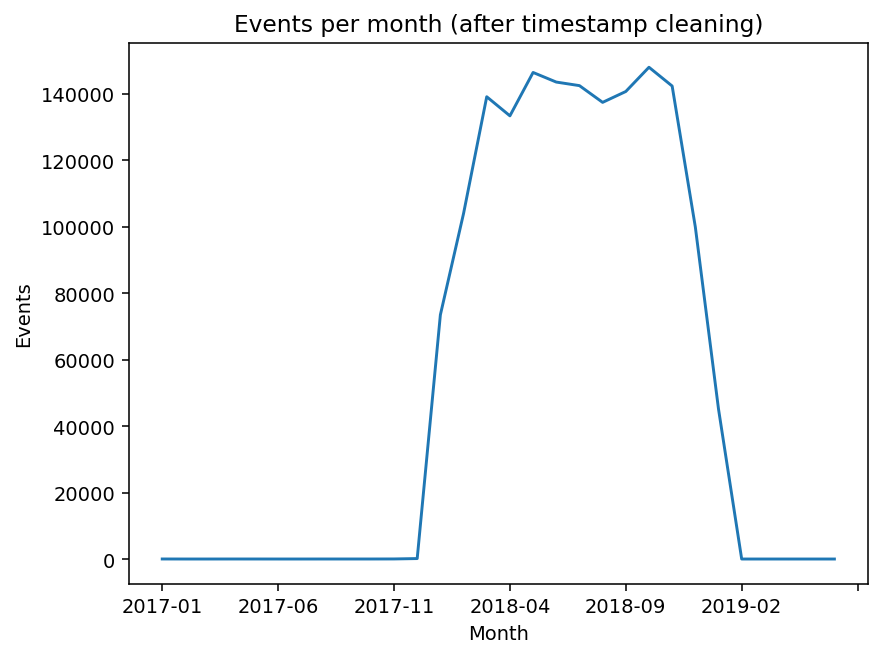

In [6]:

# Events over time (monthly)
tmp = df.copy()
tmp["month"] = tmp[TS_COL].dt.to_period("M").astype(str)
monthly = tmp.groupby("month").size()

plt.figure()
monthly.plot()
plt.title("Events per month (after timestamp cleaning)")
plt.xlabel("Month")
plt.ylabel("Events")
plt.tight_layout()
plt.show()


In [7]:

# -----------------------------
# Case-level feature extraction
# -----------------------------
# We build a small numeric feature table that can fit a fixed qubit budget.
# The timestamp for splitting is the *last event timestamp* per case.

g = df.sort_values(TS_COL).groupby(CASE_COL)

case_end_ts = g[TS_COL].max().rename("case_end_ts")
case_start_ts = g[TS_COL].min().rename("case_start_ts")
case_duration_hrs = ((case_end_ts - case_start_ts).dt.total_seconds() / 3600.0).rename("duration_hours")

n_events = g.size().rename("n_events")
n_unique_acts = g[ACT_COL].nunique().rename("n_unique_acts")

# Activity frequency for top activities (bounded)
top_k = max(N_QUBITS - 4, 2)  # leave room for generic features
top_activities = df[ACT_COL].value_counts().head(top_k).index.tolist()

# Use a dummy numeric column for pivoting.
# Using values=ACT_COL can trigger a pandas grouping edge case on wide frames.
tmp_act = df.loc[df[ACT_COL].isin(top_activities), [CASE_COL, ACT_COL]].copy()
tmp_act["_one"] = 1
act_counts = (
    tmp_act.pivot_table(index=CASE_COL, columns=ACT_COL, values="_one", aggfunc="sum", fill_value=0)
)

# Compose case-level table
case_df = pd.concat([case_end_ts, case_start_ts, case_duration_hrs, n_events, n_unique_acts, act_counts], axis=1)
case_df = case_df.fillna(0).reset_index()

# Rename activity columns to stable names
rename_map = {}
for i, a in enumerate(top_activities):
    rename_map[a] = f"act_top_{i+1}"
case_df = case_df.rename(columns=rename_map)

# Build a numeric feature matrix
feature_cols = ["duration_hours", "n_events", "n_unique_acts"] + [f"act_top_{i+1}" for i in range(len(top_activities))]
# Ensure exactly N_QUBITS features by trimming/padding (simple)
if len(feature_cols) > N_QUBITS:
    feature_cols = feature_cols[:N_QUBITS]
elif len(feature_cols) < N_QUBITS:
    # pad with zeros (rare)
    for j in range(N_QUBITS - len(feature_cols)):
        col = f"pad_{j+1}"
        case_df[col] = 0.0
        feature_cols.append(col)

# Convert case end timestamp to a naive datetime for sorting/splitting.
_ts = pd.to_datetime(case_df["case_end_ts"], errors="coerce")
# If timestamps are tz-aware, drop timezone; otherwise keep as-is.
if getattr(_ts.dt, "tz", None) is not None:
    _ts = _ts.dt.tz_convert(None)
case_df["posting_date"] = _ts

case_df = case_df.sort_values("posting_date").reset_index(drop=True)

print("Case-level rows:", len(case_df))
print("Feature columns:", feature_cols)
display(case_df.head(3))


Case-level rows: 251734
Feature columns: ['duration_hours', 'n_events', 'n_unique_acts', 'act_top_1', 'act_top_2', 'act_top_3', 'act_top_4', 'pad_1']


,case:concept:name,case_end_ts,case_start_ts,duration_hours,n_events,n_unique_acts,act_top_2,act_top_1,act_top_3,act_top_4,pad_1,posting_date
0,4507000358_00020,2018-01-02 11:25:00+00:00,2018-01-02 11:22:00+00:00,0.05,3,3,1,0,0,0,0.0,2018-01-02 11:25:00
1,4507000363_00010,2018-01-02 11:35:00+00:00,2018-01-02 11:35:00+00:00,0.00,2,2,1,0,0,0,0.0,2018-01-02 11:35:00
2,4507000364_00010,2018-01-02 11:36:00+00:00,2018-01-02 11:36:00+00:00,0.00,2,2,1,0,0,0,0.0,2018-01-02 11:36:00


In [8]:

# -----------------------------
# Temporal split with guard band
# -----------------------------
def temporal_split_with_guard(dates: pd.Series, guard_days: int = 7) -> Dict[str, np.ndarray]:
    # Split by quantiles of time; remove guard band near boundaries.
    # 60/20/20 by time.
    d = pd.to_datetime(dates)
    t0, t1, t2, t3 = d.min(), d.quantile(0.6), d.quantile(0.8), d.max()
    guard = pd.Timedelta(days=guard_days)

    train_mask = d <= (t1 - guard)
    val_mask   = (d >= (t1 + guard)) & (d <= (t2 - guard))
    test_mask  = d >= (t2 + guard)

    return {"train": train_mask.values, "val": val_mask.values, "test": test_mask.values,
            "bounds": (t0, t1, t2, t3)}

masks = temporal_split_with_guard(case_df["posting_date"], guard_days=GUARD_DAYS)
print("Bounds:", masks["bounds"])
print("Train/Val/Test sizes:", masks["train"].sum(), masks["val"].sum(), masks["test"].sum())

# Keep only rows that fall into one of the sets
keep = masks["train"] | masks["val"] | masks["test"]
case_df2 = case_df.loc[keep].copy()

train = case_df2.loc[masks["train"][keep]].copy()
val   = case_df2.loc[masks["val"][keep]].copy()
test  = case_df2.loc[masks["test"][keep]].copy()

print("After guard/keep:", len(case_df2), "rows")
print("Train/Val/Test:", len(train), len(val), len(test))


Bounds: (Timestamp('2018-01-02 11:25:00'), Timestamp('2018-10-09 10:13:00'), Timestamp('2018-12-07 08:06:00'), Timestamp('2020-04-09 21:59:00'))
Train/Val/Test sizes: 142555 39589 42410
After guard/keep: 224554 rows
Train/Val/Test: 142555 39589 42410


In [9]:

# -----------------------------
# Robust scaling (median + MAD)
# -----------------------------
def robust_fit(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    med = np.median(X, axis=0)
    mad = np.median(np.abs(X - med), axis=0)
    mad = np.where(mad == 0, 1.0, mad)
    return med, mad

def robust_transform(X: np.ndarray, med: np.ndarray, mad: np.ndarray) -> np.ndarray:
    return (X - med) / (1.4826 * mad)

X_train = train[feature_cols].to_numpy(dtype=float)
X_val   = val[feature_cols].to_numpy(dtype=float)
X_test  = test[feature_cols].to_numpy(dtype=float)

med, mad = robust_fit(X_train)
X_train_s = robust_transform(X_train, med, mad)
X_val_s   = robust_transform(X_val, med, mad)
X_test_s  = robust_transform(X_test, med, mad)

print("Scaled shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)


Scaled shapes: (142555, 8) (39589, 8) (42410, 8)


In [10]:

# -----------------------------
# Controlled anomaly injection (proxy labels)
# -----------------------------
# BPIC2019 has no anomaly labels. We inject anomalies only for evaluation.
# We inject in the *test* split (and a very small amount in val to support PR curves),
# leaving training effectively nominal.

def inject_anomalies(X: np.ndarray, frac: float, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    n = len(X)
    y = np.zeros(n, dtype=int)
    m = max(1, int(frac * n))
    idx = rng.choice(n, size=m, replace=False)
    y[idx] = 1
    X2 = X.copy()
    # Perturb selected rows: heavy-tailed noise + feature spikes
    noise = rng.normal(loc=0.0, scale=3.0, size=(m, X.shape[1]))
    spikes = rng.choice([0.0, 6.0], size=(m, X.shape[1]), p=[0.7, 0.3])
    X2[idx] = X2[idx] + noise + spikes
    return X2, y

# Inject proxy anomalies
X_val_s_lbl, y_val = inject_anomalies(X_val_s, frac=0.01, rng=rng)
X_test_s_lbl, y_test = inject_anomalies(X_test_s, frac=0.03, rng=rng)

# We treat the "validation normals" as y_val == 0 for threshold calibration
print("Val anomalies:", y_val.sum(), "Test anomalies:", y_test.sum())


Val anomalies: 395 Test anomalies: 1272


In [11]:

# -----------------------------
# Baselines: Robust Z-score, PCA reconstruction error, KMeans distance
# -----------------------------
def score_robustz(Xs: np.ndarray) -> np.ndarray:
    # In scaled space, robust z-score magnitude (L1) works as a simple anomaly score
    return np.mean(np.abs(Xs), axis=1)

def score_pca_recon(X_train_s: np.ndarray, X_s: np.ndarray, var_keep: float = 0.95, max_comp: int = None) -> np.ndarray:
    pca = PCA(n_components=var_keep, svd_solver="full", random_state=SEED)
    pca.fit(X_train_s)
    if max_comp is not None and pca.n_components_ > max_comp:
        pca = PCA(n_components=max_comp, svd_solver="full", random_state=SEED)
        pca.fit(X_train_s)
    X_proj = pca.transform(X_s)
    X_rec = pca.inverse_transform(X_proj)
    return np.mean((X_s - X_rec) ** 2, axis=1)

def score_kmeans_dist(X_train_s: np.ndarray, X_s: np.ndarray, k: int = 5) -> np.ndarray:
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    km.fit(X_train_s)
    centers = km.cluster_centers_
    # distance to nearest centroid
    d = np.sqrt(((X_s[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2))
    return d.min(axis=1)

# Choose k simply (fixed) for the pilot to stay deterministic and transparent
K_FIXED = 5

scores = {}
scores["RobustZ"] = score_robustz(X_test_s_lbl)

scores["PCA"] = score_pca_recon(X_train_s, X_test_s_lbl, var_keep=0.95, max_comp=min(6, X_train_s.shape[1]))

scores["KMeans"] = score_kmeans_dist(X_train_s, X_test_s_lbl, k=K_FIXED)

for k, v in scores.items():
    print(k, "score range:", float(np.min(v)), float(np.max(v)))


RobustZ score range: 0.0001755625751944931 136.06035755412796
PCA score range: 0.002080450846752708 4721.206798794211
KMeans score range: 0.30562203701579566 521.3219017093681


In [12]:

# -----------------------------
# PQF-like quantum fidelity kernel (statevector)
# -----------------------------
# We use a simple feature map that encodes scaled features into Ry rotations
# and adds entanglement. The fidelity kernel is |<psi(x)|psi(x')>|^2.

def pqf_feature_map(x: np.ndarray, n_qubits: int, depth: int = 1) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits)
    # Angle embedding + simple entanglement; keep it small for simulation
    for d in range(depth):
        for i in range(n_qubits):
            qc.ry(float(x[i]), i)
        for i in range(n_qubits - 1):
            qc.cx(i, i + 1)
        qc.barrier()
    return qc

def state_from_x(x: np.ndarray, n_qubits: int, depth: int) -> Statevector:
    qc = pqf_feature_map(x, n_qubits=n_qubits, depth=depth)
    return Statevector.from_instruction(qc)

def fidelity_kernel_matrix(Xa: np.ndarray, Xb: np.ndarray, n_qubits: int, depth: int,
                           max_a: int = None, max_b: int = None) -> np.ndarray:
    if max_a is not None:
        Xa = Xa[:max_a]
    if max_b is not None:
        Xb = Xb[:max_b]
    # Precompute states
    Sa = [state_from_x(x, n_qubits, depth) for x in Xa]
    Sb = [state_from_x(x, n_qubits, depth) for x in Xb]
    K = np.zeros((len(Sa), len(Sb)), dtype=float)
    for i, sa in enumerate(Sa):
        for j, sb in enumerate(Sb):
            amp = sa.data.conjugate().dot(sb.data)
            K[i, j] = float(np.abs(amp) ** 2)
    return K

# Bound the kernel size for feasibility
n_train_k = min(len(X_train_s), MAX_CASES_FOR_KERNEL)
n_test_k  = min(len(X_test_s_lbl), MAX_CASES_FOR_KERNEL)

Xtr_k = X_train_s[:n_train_k]
Xte_k = X_test_s_lbl[:n_test_k]
yte_k = y_test[:n_test_k]

t0 = time.time()
K_train = fidelity_kernel_matrix(Xtr_k, Xtr_k, n_qubits=N_QUBITS, depth=DEPTH)
t_kernel_train = time.time() - t0

t1 = time.time()
K_test = fidelity_kernel_matrix(Xte_k, Xtr_k, n_qubits=N_QUBITS, depth=DEPTH)
t_kernel_test = time.time() - t1

print("K_train shape:", K_train.shape, "time:", round(t_kernel_train, 2), "s")
print("K_test  shape:", K_test.shape, "time:", round(t_kernel_test, 2), "s")

# One-Class SVM on precomputed kernel
oc = OneClassSVM(kernel="precomputed", nu=ALPHA)  # simple tie to alpha
t2 = time.time()
oc.fit(K_train)
t_fit = time.time() - t2

# Decision function: higher means more normal -> invert to get anomaly score
t3 = time.time()
dec = oc.decision_function(K_test).ravel()
t_score = time.time() - t3
pqf_scores = -dec

scores["QuantumPQF"] = pqf_scores

print("OCSVM fit time:", round(t_fit, 2), "s; scoring time:", round(t_score, 2), "s")


K_train shape: (900, 900) time: 1.34 s
K_test  shape: (900, 900) time: 1.37 s
OCSVM fit time: 0.0 s; scoring time: 0.0 s


In [13]:

# -----------------------------
# Threshold calibration at alpha on validation normals + evaluation
# -----------------------------
def calibrate_threshold(scores_val: np.ndarray, y_val: np.ndarray, alpha: float) -> float:
    # Use validation normals only; threshold at (1-alpha) quantile
    normals = scores_val[y_val == 0]
    return float(np.quantile(normals, 1.0 - alpha))

def pr_auc(y_true: np.ndarray, scores_: np.ndarray) -> float:
    return float(average_precision_score(y_true, scores_))

def precision_recall_at_threshold(y_true: np.ndarray, scores_: np.ndarray, thr: float) -> Tuple[float, float]:
    y_hat = (scores_ >= thr).astype(int)
    tp = int(((y_hat == 1) & (y_true == 1)).sum())
    fp = int(((y_hat == 1) & (y_true == 0)).sum())
    fn = int(((y_hat == 0) & (y_true == 1)).sum())
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    return float(precision), float(recall)

# Build validation scores for each method using the same scoring definitions
val_scores = {}
val_scores["RobustZ"] = score_robustz(X_val_s_lbl)
val_scores["PCA"] = score_pca_recon(X_train_s, X_val_s_lbl, var_keep=0.95, max_comp=min(6, X_train_s.shape[1]))
val_scores["KMeans"] = score_kmeans_dist(X_train_s, X_val_s_lbl, k=K_FIXED)

# For PQF, we calibrate using the bounded subset too
n_val_k = min(len(X_val_s_lbl), MAX_CASES_FOR_KERNEL)
Xva_k = X_val_s_lbl[:n_val_k]
yva_k = y_val[:n_val_k]
K_val = fidelity_kernel_matrix(Xva_k, Xtr_k, n_qubits=N_QUBITS, depth=DEPTH)
val_dec = oc.decision_function(K_val).ravel()
val_scores["QuantumPQF"] = -val_dec

rows = []
for name, sc_test in scores.items():
    sc_val = val_scores[name]
    y_val_use = yva_k if name == "QuantumPQF" else y_val
    sc_val_use = sc_val[:len(y_val_use)]

    thr = calibrate_threshold(sc_val_use, y_val_use, alpha=ALPHA)
    y_test_use = yte_k if name == "QuantumPQF" else y_test
    sc_test_use = sc_test[:len(y_test_use)]

    auc = pr_auc(y_test_use, sc_test_use)
    p, r = precision_recall_at_threshold(y_test_use, sc_test_use, thr)

    rows.append({
        "method": name,
        "pr_auc": auc,
        "precision_at_alpha": p,
        "recall_at_alpha": r,
        "alpha": ALPHA,
        "n_test_used": int(len(y_test_use))
    })

res = pd.DataFrame(rows).sort_values("pr_auc", ascending=False).reset_index(drop=True)
display(res)

csv_path = os.path.join(OUT_DIR, "results_table.csv")
res.to_csv(csv_path, index=False)
print("Saved:", csv_path)


,method,pr_auc,precision_at_alpha,recall_at_alpha,alpha,n_test_used
0,QuantumPQF,0.882650,0.676471,0.884615,0.01,900
1,PCA,0.694832,0.503626,0.982704,0.01,42410
2,KMeans,0.561197,0.641379,0.877358,0.01,42410
3,RobustZ,0.551977,0.685976,0.884434,0.01,42410


Saved: outputs_pqf_bpic2019/results_table.csv


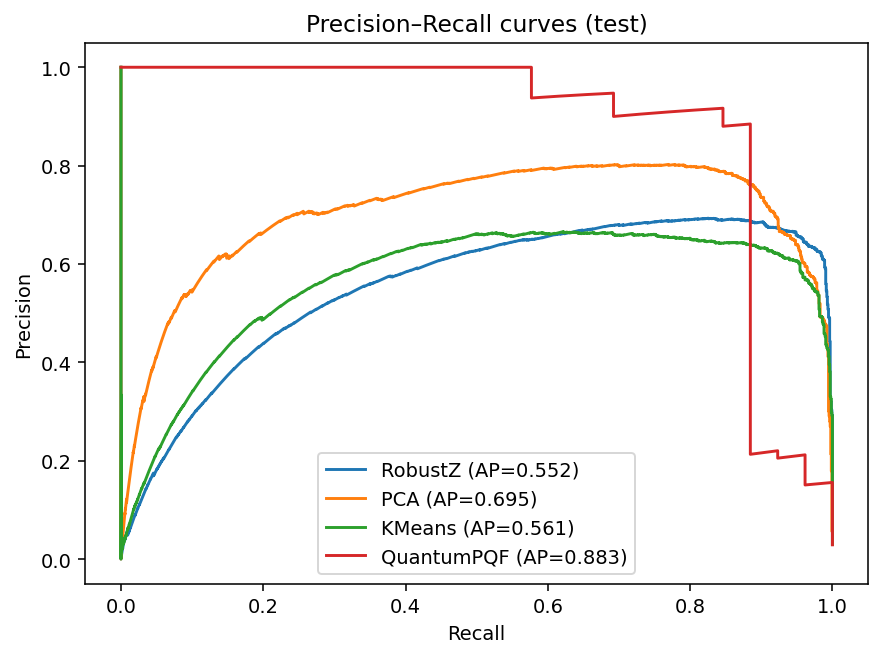

Saved: outputs_pqf_bpic2019/figure_pr_curves.png


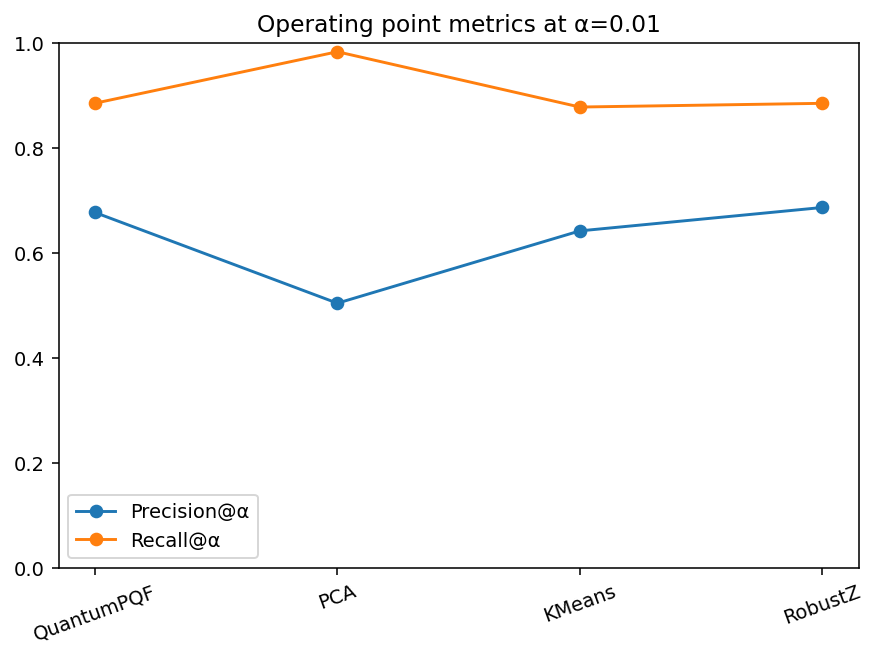

Saved: outputs_pqf_bpic2019/figure_precision_recall_at_alpha.png


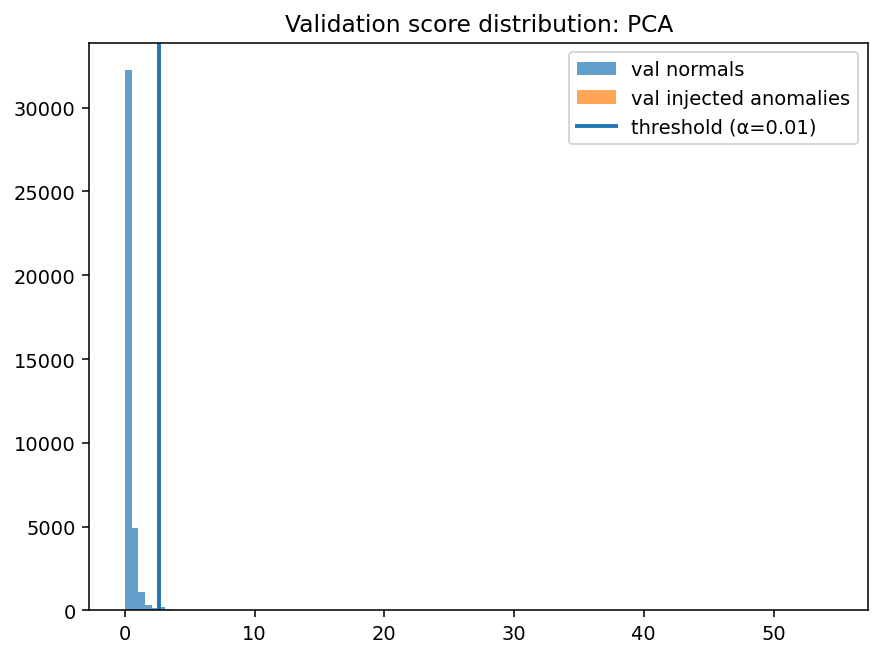

Saved: outputs_pqf_bpic2019/figure_val_scores_PCA.png


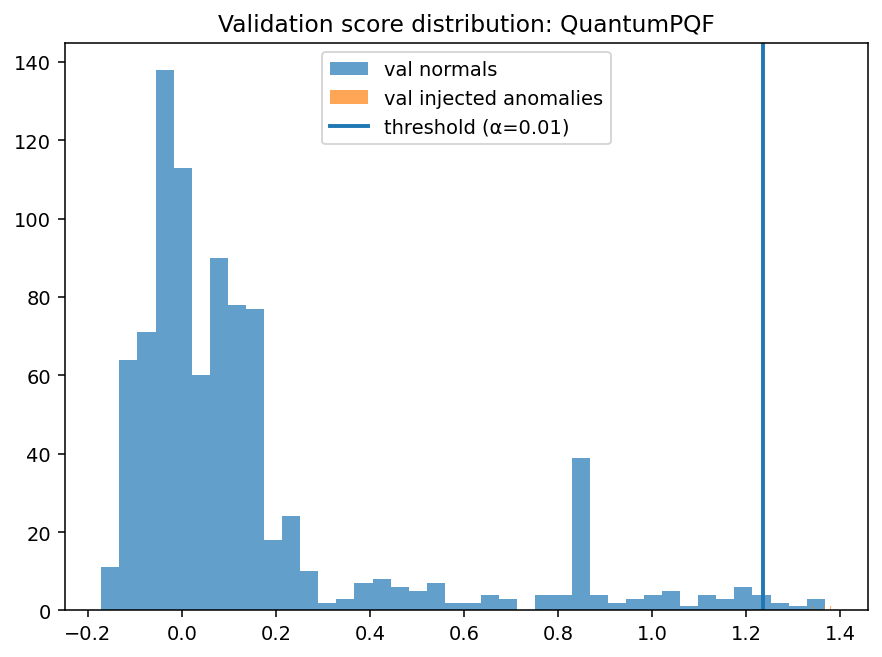

Saved: outputs_pqf_bpic2019/figure_val_scores_QuantumPQF.png


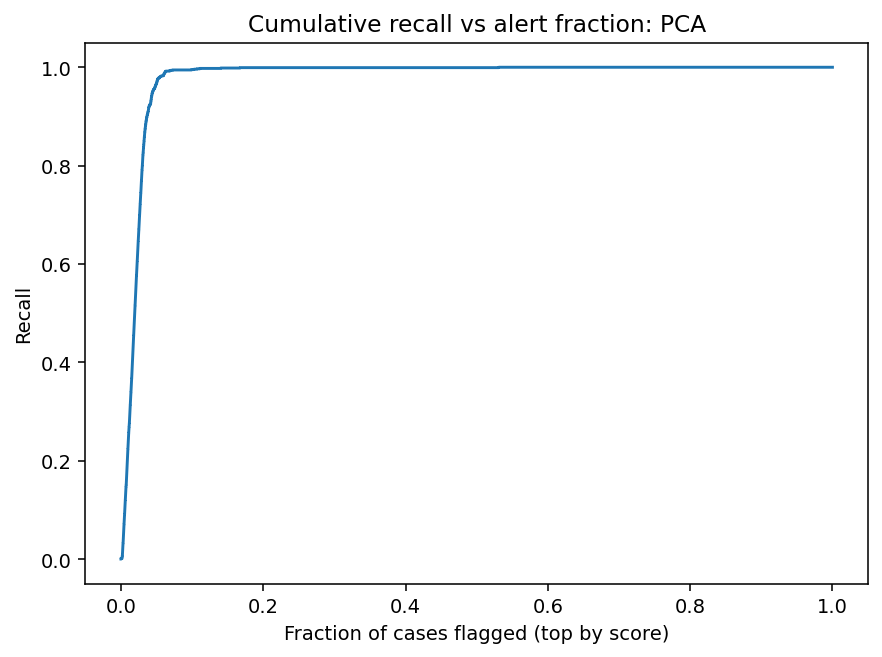

Saved: outputs_pqf_bpic2019/figure_cum_recall_PCA.png


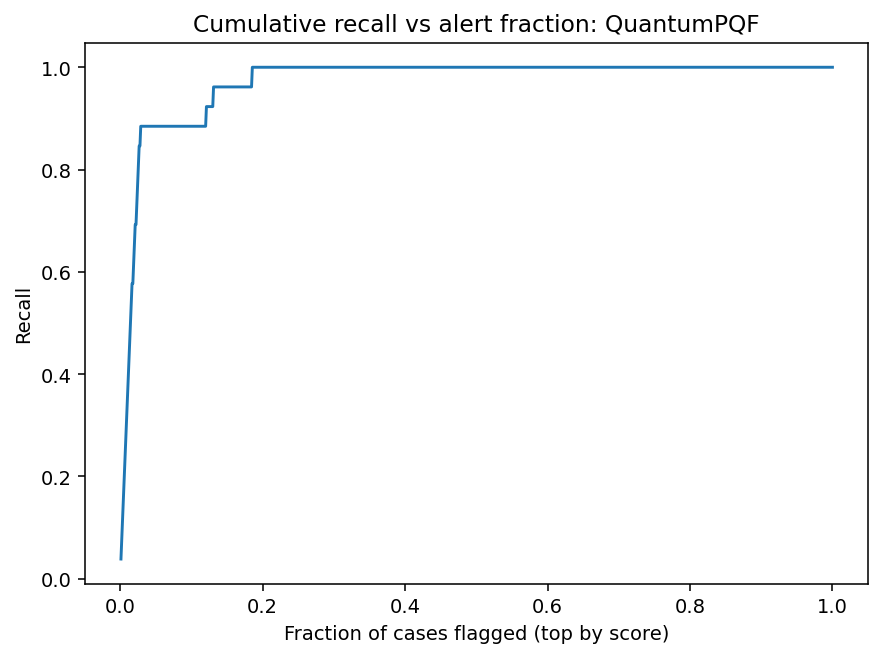

Saved: outputs_pqf_bpic2019/figure_cum_recall_QuantumPQF.png


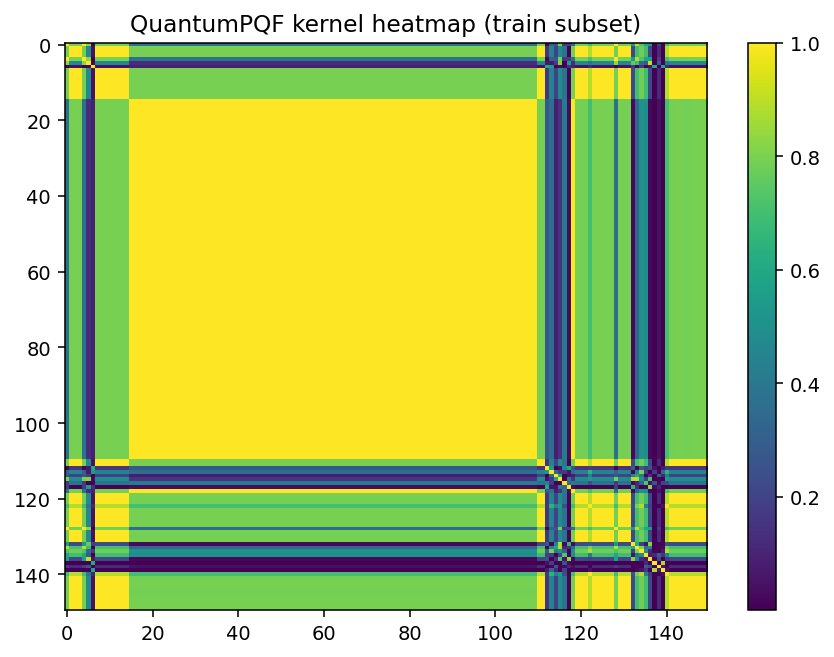

Saved: outputs_pqf_bpic2019/figure_kernel_heatmap_QuantumPQF.png


In [14]:

# -----------------------------
# Plots for Chapter 4.2
# -----------------------------
# 1) PR curves
plt.figure()
for name in ["RobustZ", "PCA", "KMeans", "QuantumPQF"]:
    if name == "QuantumPQF":
        y = yte_k
        s = scores[name][:len(y)]
    else:
        y = y_test
        s = scores[name]
    prec, rec, _ = precision_recall_curve(y, s)
    plt.plot(rec, prec, label=f"{name} (AP={average_precision_score(y, s):.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curves (test)")
plt.legend()
plt.tight_layout()
pr_path = os.path.join(OUT_DIR, "figure_pr_curves.png")
plt.savefig(pr_path)
plt.show()
print("Saved:", pr_path)

# 2) Precision/Recall at alpha (bar-like plot)
labels = res["method"].tolist()
x = np.arange(len(labels))
plt.figure()
plt.plot(x, res["precision_at_alpha"], marker="o", label="Precision@α")
plt.plot(x, res["recall_at_alpha"], marker="o", label="Recall@α")
plt.xticks(x, labels, rotation=20)
plt.ylim(0, 1.0)
plt.title(f"Operating point metrics at α={ALPHA}")
plt.legend()
plt.tight_layout()
op_path = os.path.join(OUT_DIR, "figure_precision_recall_at_alpha.png")
plt.savefig(op_path)
plt.show()
print("Saved:", op_path)

# 3) Validation-normal score distribution + threshold for PQF and PCA
def plot_val_hist(name: str, sc_val: np.ndarray, yv: np.ndarray, thr: float):
    plt.figure()
    normals = sc_val[yv == 0]
    anomalies = sc_val[yv == 1]
    plt.hist(normals, bins=40, alpha=0.7, label="val normals")
    if len(anomalies) > 0:
        plt.hist(anomalies, bins=40, alpha=0.7, label="val injected anomalies")
    plt.axvline(thr, linewidth=2, label=f"threshold (α={ALPHA})")
    plt.title(f"Validation score distribution: {name}")
    plt.legend()
    plt.tight_layout()
    path = os.path.join(OUT_DIR, f"figure_val_scores_{name}.png")
    plt.savefig(path)
    plt.show()
    print("Saved:", path)

# PCA
thr_pca = calibrate_threshold(val_scores["PCA"], y_val, ALPHA)
plot_val_hist("PCA", val_scores["PCA"], y_val, thr_pca)

# PQF (bounded)
thr_pqf = calibrate_threshold(val_scores["QuantumPQF"][:len(yva_k)], yva_k, ALPHA)
plot_val_hist("QuantumPQF", val_scores["QuantumPQF"][:len(yva_k)], yva_k, thr_pqf)

# 4) Cumulative recall vs fraction of alerts (test)
def cumulative_recall_plot(y: np.ndarray, s: np.ndarray, name: str):
    order = np.argsort(-s)
    y_sorted = y[order]
    cum_tp = np.cumsum(y_sorted == 1)
    total_pos = max(1, int((y == 1).sum()))
    recall_curve = cum_tp / total_pos
    frac_alerts = (np.arange(len(y_sorted)) + 1) / len(y_sorted)

    plt.figure()
    plt.plot(frac_alerts, recall_curve)
    plt.xlabel("Fraction of cases flagged (top by score)")
    plt.ylabel("Recall")
    plt.title(f"Cumulative recall vs alert fraction: {name}")
    plt.tight_layout()
    path = os.path.join(OUT_DIR, f"figure_cum_recall_{name}.png")
    plt.savefig(path)
    plt.show()
    print("Saved:", path)

cumulative_recall_plot(y_test, scores["PCA"], "PCA")
cumulative_recall_plot(yte_k, scores["QuantumPQF"][:len(yte_k)], "QuantumPQF")

# 5) Kernel heatmap for PQF (small view)
m = min(150, len(Xtr_k))
K_small = K_train[:m, :m]
plt.figure()
plt.imshow(K_small, aspect="auto")
plt.title("QuantumPQF kernel heatmap (train subset)")
plt.colorbar()
plt.tight_layout()
k_path = os.path.join(OUT_DIR, "figure_kernel_heatmap_QuantumPQF.png")
plt.savefig(k_path)
plt.show()
print("Saved:", k_path)


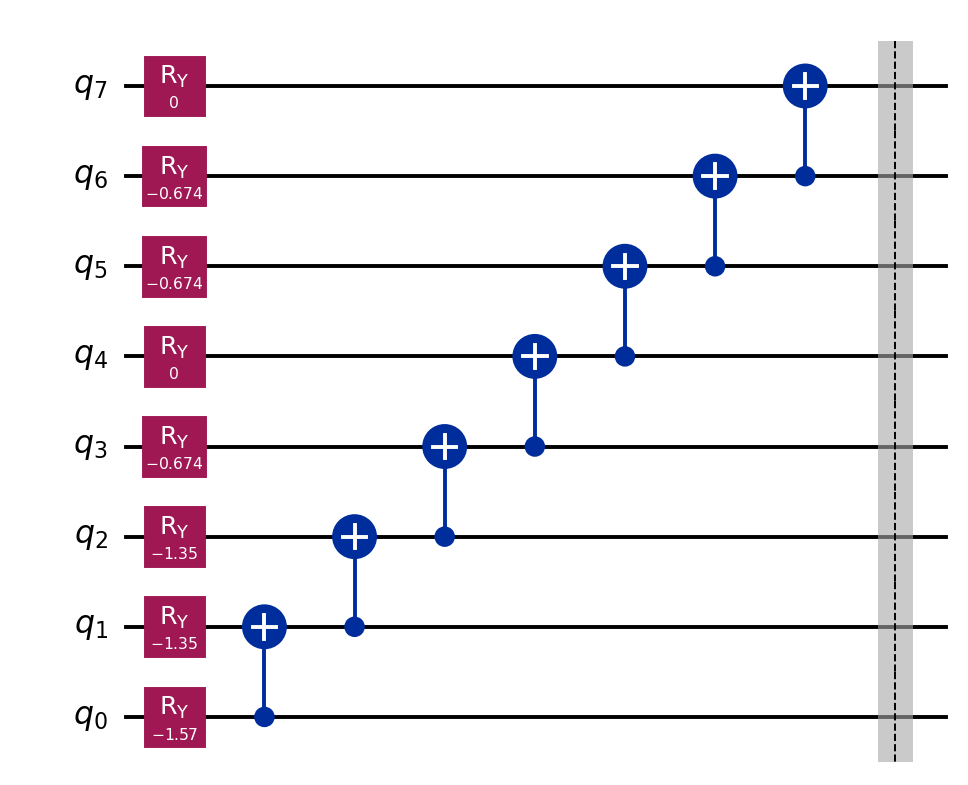

Saved: outputs_pqf_bpic2019/figure_pqf_feature_map_8q_depth1_reverse_bits.png
Angles used for visualization (clipped):
  q0: Ry(-1.569)
  q1: Ry(-1.349)
  q2: Ry(-1.349)
  q3: Ry(-0.674)
  q4: Ry(0.000)
  q5: Ry(-0.674)
  q6: Ry(-0.674)
  q7: Ry(0.000)


In [16]:
# -----------------------------
# Circuit figures (pilot-faithful)
# -----------------------------
# This draws the PQF feature-map circuit used in the pilot:
# - N_QUBITS qubits
# - DEPTH layers
# - rotation angles taken from a real (scaled) data point

from IPython.display import display
from qiskit import QuantumCircuit
import numpy as np
import os

# Safety: choose a real vector from the training split (scaled features)
# This makes the Ry angles visible in the diagram.
if "X_train_s" not in globals():
    raise RuntimeError("Run the scaling cell first so X_train_s exists.")

x_vis = X_train_s[0].copy()

# Optional: clip angles only for readability of the figure (does not change the pilot method)
# Keep it mild to still reflect real values.
x_vis = np.clip(x_vis, -2.0, 2.0)

# Build the exact feature map circuit used by the pilot (same function, same depth)
qc_pqf = pqf_feature_map(x_vis, n_qubits=N_QUBITS, depth=DEPTH)
qc_pqf.name = f"PQF_FeatureMap_{N_QUBITS}q_depth{DEPTH}"

fig_pqf_rb = qc_pqf.draw(output="mpl", fold=140, reverse_bits=True)
display(fig_pqf_rb)

png_pqf_rb = os.path.join(OUT_DIR, f"figure_pqf_feature_map_{N_QUBITS}q_depth{DEPTH}_reverse_bits.png")
fig_pqf_rb.savefig(png_pqf_rb, dpi=300, bbox_inches="tight")
print("Saved:", png_pqf_rb)

# Print the angles used (Chapter 3)
print("Angles used for visualization (clipped):")
for i, a in enumerate(x_vis):
    print(f"  q{i}: Ry({a:.3f})")